# 车票二维码检测与识别课题报告

姓名：石淳安  学号

姓名：李铄   学号：1800012971

## 一、算法目的和应用
火车票票面包含很多有效信息，受到光照和噪声的影响其中二维码图像常常无法正确识别。通过以下的车票二维码检测与识别算法，可以有效的对原始图像进行去噪和调整，提高二维码识别的正确率。

## 二、算法设计和流程
### （一）车票票面检测
通过滤波、二值化等预处理，对图像进行轮廓检测，找出票面对应的矩形框位置并将其对齐摆正。
#### 1.1 预处理
- 对原始图像上下左右各填充100像素
- 使用5*5的中值滤波去除噪声，二值化方便后续处理
- 形态学处理，闭操作使车票内部成为白色，背景成为黑色

Text(0.5, 1.0, 'Closed image')

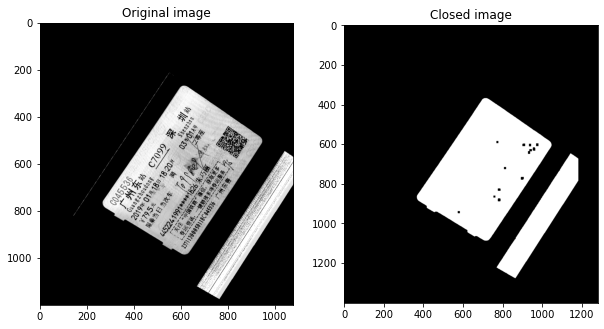

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
shape_x, shape_y = int(856 / 1.5), int(540 / 1.5) # 蓝票标准长宽比
outer_x, outer_y = 20, 20

ori_img = "train/0008.bmp"
ori_img = cv2.imread(ori_img, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(ori_img, cmap='gray')
plt.title("Original image")

# padding
padding = 100
ori_img = np.pad(ori_img, ((padding, padding), (padding, padding)), 'constant', constant_values=(0, 0))

# 中值滤波去除噪声
blurred_img = cv2.medianBlur(ori_img, 5)
_, thres_img = cv2.threshold(blurred_img, 80, 255, cv2.THRESH_BINARY)

# 形态学处理，闭操作使车票内部尽可能成为白色，背景尽可能成为黑色
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
morphed_img = cv2.morphologyEx(thres_img, cv2.MORPH_CLOSE, kernel)

plt.subplot(122)
plt.imshow(morphed_img, cmap='gray')
plt.title("Closed image")

#### 1.2 轮廓提取
- 使用Canny算子提取边缘特征
- 计算其中面积最大的轮廓认为是票面区域
- 当车票在图像中不完整时，由于缺少一个或多个角，得到的轮廓可能不是矩形。因此对轮廓求其凸包和顶点，当顶点数大于4时调用handle_not_rect()方法修正多边形，直到得到矩形

Text(0.5, 1.0, 'Max contour')

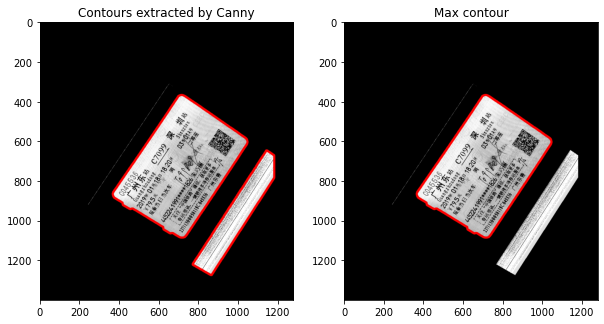

In [2]:
# 使用Canny算子提取边缘特征
canny = cv2.Canny(morphed_img, 40, 150)
contours, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contour_img = cv2.cvtColor(ori_img, cv2.COLOR_GRAY2BGR)
contours, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_img = cv2.drawContours(contour_img, contours, -1, (255, 0, 0), 10)

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(contour_img, cmap='gray')
plt.title("Contours extracted by Canny")

# 认为轮廓中面积最大的区域即为票面所在区域
max_contour ,max_area = 0, 0
for contour in contours:
    tmp = cv2.contourArea(contour)
    if tmp > max_area:
        max_contour, max_area = contour, tmp

# 得到矩形顶点
poly_contour = cv2.approxPolyDP(max_contour, 0.02 * cv2.arcLength(max_contour, True), True)
points = poly_contour.squeeze()

contour_img = cv2.cvtColor(ori_img, cv2.COLOR_GRAY2BGR)
contour_img = cv2.drawContours(contour_img, [max_contour], -1, (255, 0, 0), 10)

plt.subplot(122)
plt.imshow(contour_img, cmap='gray')
plt.title("Max contour")


Text(0.5, 1.0, 'Rectangle')

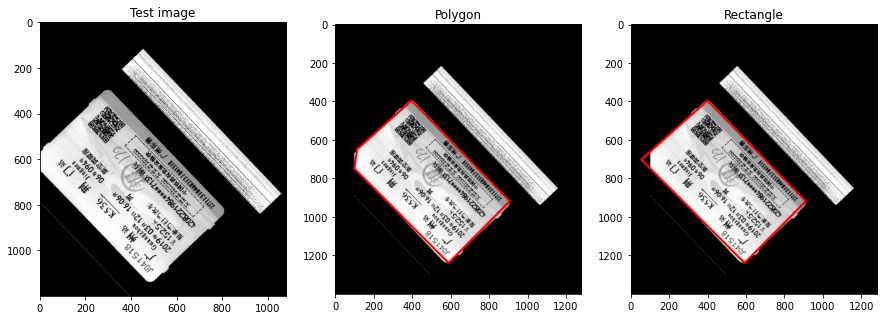

In [3]:
# 辅助的两个函数模块
# 求解点p1, p2所在直线与点p3, p4所在直线交点
def solve(p1, p2, p3, p4):
    A = np.array([[p2[1]-p1[1], p1[0]-p2[0]], [p4[1]-p3[1], p3[0]-p4[0]]])
    B1 = np.array([[(p2[1]-p1[1])*p1[0]+(p1[0]-p2[0])*p1[1], p1[0]-p2[0]], 
                  [(p4[1]-p3[1])*p3[0]+(p3[0]-p4[0])*p3[1], p3[0]-p4[0]]])
    B2 = np.array([[p2[1]-p1[1], (p2[1]-p1[1])*p1[0]+(p1[0]-p2[0])*p1[1]],
                  [p4[1]-p3[1], (p4[1]-p3[1])*p3[0]+(p3[0]-p4[0])*p3[1]]])
    A, B1, B2 = map(lambda x: np.linalg.det(x), (A, B1, B2))
    return B1/A, B2/A

# 合并距离最短的两点，并根据最短边的相邻两边求解其交点
def handle_not_rect(points):
    new_points = np.zeros((points.shape[0] - 1, points.shape[1]))
    dist_list = [np.linalg.norm(points[i] - points[i - 1]) for i in range(points.shape[0])]
    i = np.argmin(np.array(dist_list)) # 缩点(i-2, i-1), (i, i+1)
    x, y = solve(points[i-2], points[i-1], points[i], points[(i+1)%points.shape[0]])
    if i > 0:
        new_points[:i-1, :] = points[:i-1, :]
    new_points[i-1, :] = np.array([x, y])
    new_points[i:, :] = points[i+1:, :]
    return new_points
 
# 以75号图为例
test_img = "train/0075.bmp"
test_img = cv2.imread(test_img, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(test_img, cmap='gray')
plt.title("Test image")

# 预处理
padding = 100
test_img = np.pad(test_img, ((padding, padding), (padding, padding)), 'constant', constant_values=(0, 0))
blurred_img = cv2.medianBlur(test_img, 5)
_, thres_img = cv2.threshold(blurred_img, 80, 255, cv2.THRESH_BINARY)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
morphed_img = cv2.morphologyEx(thres_img, cv2.MORPH_CLOSE, kernel)
canny = cv2.Canny(morphed_img, 40, 150)
contours, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
max_contour ,max_area = 0, 0
for contour in contours:
    tmp = cv2.contourArea(contour)
    if tmp > max_area:
        max_contour, max_area = contour, tmp

# 对轮廓求其凸包和顶点，当顶点数大于4时调用handle_not_rect()方法修正多边形，直到得到矩形
poly_contour = cv2.approxPolyDP(max_contour, 0.02 * cv2.arcLength(max_contour, True), True)
points_ = poly_contour.squeeze()

contour_img = cv2.cvtColor(test_img, cv2.COLOR_GRAY2BGR)
contour_img = cv2.drawContours(contour_img, [poly_contour], -1, (255, 0, 0), 10)
plt.subplot(132)
plt.imshow(contour_img)
plt.title("Polygon")

while points_.shape[0] > 4:
    points_ = handle_not_rect(points_)

poly_contour2 = points_.reshape((4, 1, 2)).astype(np.int32)
contour_img = cv2.cvtColor(test_img, cv2.COLOR_GRAY2BGR)
contour_img = cv2.drawContours(contour_img, [poly_contour2], -1, (255, 0, 0), 10)
plt.subplot(133)
plt.imshow(contour_img)
plt.title("Rectangle")


#### 1.3 透视变换
- 将矩形的四个顶点顺序变换为右旋
- 根据火车票标准尺寸确定目标的四个顶点进行透视变换
  - 仿射变换会使图像产生一定程度的变形，相比之下透视变换效果更好

Text(0.5, 1.0, 'Affine transform')

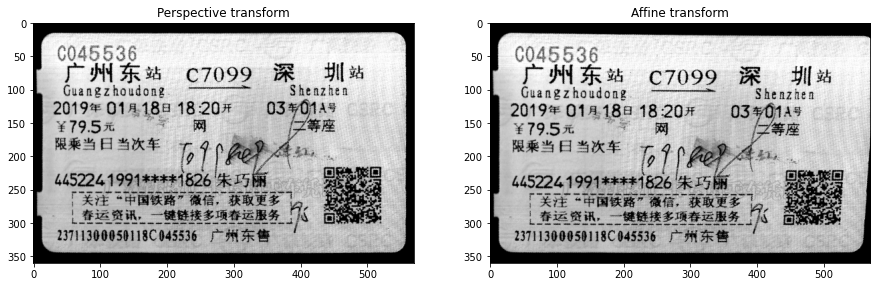

In [4]:
# 修正为右旋标价
c = np.cross(points[1]-points[0], points[2]-points[1])
if c > 0:   
    points = points[::-1, :]

# 短边优先
len1 = np.linalg.norm(points[0] - points[1])
len2 = np.linalg.norm(points[1] - points[2])
if len1 >= len2:    
    points = np.roll(points, 1, axis=0)

# y值小的优先
if points[0][0] > points[2][0]: 
    points = np.roll(points, 2, axis=0)

# 透视变换
N = np.array([[outer_x, outer_y], [outer_x, shape_y - outer_y], 
            [shape_x - outer_x, shape_y - outer_y], [shape_x - outer_x, outer_y]])
mat = cv2.getPerspectiveTransform(points.astype(np.float32), N.astype(np.float32))
output1 = cv2.warpPerspective(ori_img, mat, (shape_x, shape_y))

# 仿射变换
mat = cv2.getAffineTransform(points[:3].astype(np.float32), N[:3].astype(np.float32))
output2 = cv2.warpAffine(ori_img, mat, (shape_x, shape_y))

plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(output1, cmap='gray')
plt.title("Perspective transform")

plt.subplot(122)
plt.imshow(output2, cmap='gray')
plt.title("Affine transform")

#### 1.4 对齐摆正
- 霍夫变换进行直线检测
- 根据其中横线的平均偏转角度对图像进行微调
- 由于二维码的位置灰度值偏低，因此根据二值图中左上角与右下角的平均灰度比较判断图像是否摆正

Text(0.5, 1.0, 'Ticket image')

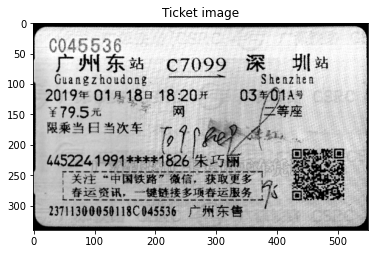

In [5]:
# 霍夫变换进行直线检测
lines = cv2.HoughLines(canny, 1, np.pi / 180, 100)
lines = lines.squeeze()

# 根据其中横线的平均偏转角度对图像进行微调
angle, cnt = 0, 0
for _, theta in lines:
    theta = theta * 180 / np.pi - 90
    if np.abs(theta) < 10:
        angle = angle * cnt + theta
        cnt += 1
        angle /= cnt
mat = cv2.getRotationMatrix2D((shape_x/2, shape_y/2), angle, 1)
fixed_img = cv2.warpAffine(output1, mat, (shape_x, shape_y))

# 裁剪一下边缘
ticket_img = fixed_img[outer_y>>1:shape_y-(outer_y>>1), outer_x>>1:shape_x-(outer_x>>1)]

# 根据二值图像左上角与右下角的平均灰度比较，判断图像是否摆正
img = cv2.medianBlur(ticket_img, 5)
_, thres_img = cv2.threshold(img, 80, 255, cv2.THRESH_BINARY)
r, c = thres_img.shape
lu = thres_img[outer_y>>1: int(shape_y*0.4), outer_x>>1: int(shape_x*0.25)]
rd = thres_img[r-int(shape_y*0.4):r-(outer_y>>1), c-int(shape_x*0.25): c-(outer_x>>1)]
if(np.mean(lu) < np.mean(rd)):
    ticket_img = cv2.flip(ticket_img, -1)

plt.imshow(ticket_img, cmap='gray')
plt.title("Ticket image")

### （二）车票二维码定位与分割
在摆正的图像中找到二维码的大略区域，滤波和形态学处理后提取轮廓。
#### 2.1 预处理
- 定位二维码的位置大致为右下角八分之一处，进行初步裁剪
- 中值滤波去除部分噪声
- 顶帽变换去除光照不均匀对图像的影响
- 形态学处理
  - 开操作使二维码内部尽可能成为黑色，背景尽可能成为白色
  - 闭操作使二维码与四周笔迹等污染分离

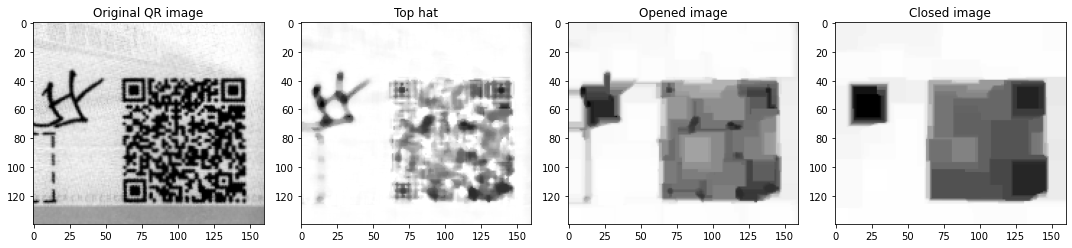

In [6]:
ticket_img = "tickets/0026.bmp"
ticket_img = cv2.imread(ticket_img, cv2.IMREAD_GRAYSCALE)

# 初步裁剪，右下角约八分之一
r, c = ticket_img.shape
crop_img = ticket_img[int(r*0.5):r-30, int(c*0.7): c-5] 

plt.figure(figsize=(15, 15))
plt.subplot(141)
plt.imshow(crop_img, cmap='gray')
plt.title("Original QR image")

# 中值滤波
blurred_img = cv2.medianBlur(crop_img, 7)
blurred_img = 255 - blurred_img

# 顶帽变换
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
morphed = cv2.morphologyEx(blurred_img, cv2.MORPH_OPEN, kernel)
top_hat = 255 - cv2.subtract(blurred_img, morphed)

plt.subplot(142)
plt.imshow(top_hat, cmap='gray')
plt.title("Top hat")

# 形态学处理，开操作使二维码内部尽可能成为黑色，背景尽可能成为白色
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
morphed_img = cv2.morphologyEx(top_hat, cv2.MORPH_OPEN, kernel)

plt.subplot(143)
plt.imshow(morphed_img, cmap='gray')
plt.title("Opened image")

# 形态学处理，闭操作使二维码与四周笔迹等污染分离
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
morphed_img = cv2.morphologyEx(morphed_img, cv2.MORPH_CLOSE, kernel)

plt.subplot(144)
plt.imshow(morphed_img, cmap='gray')
plt.title("Closed image")
plt.tight_layout()

# 二值化方便后续处理
_, morphed_img = cv2.threshold(morphed_img, np.max(morphed_img) * 0.8, 255, cv2.THRESH_BINARY)
morphed_img = np.pad(morphed_img, ((0, 2), (0, 2)),'constant', constant_values=(255,255))

#### 2.2 轮廓提取
- Canny算子提取边缘信息
- 找出其中面积最大轮廓

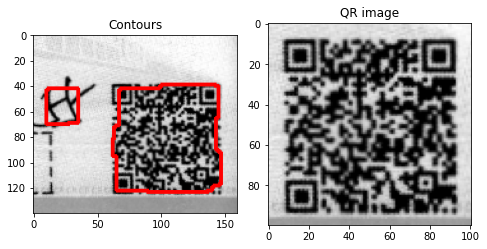

In [7]:
# Canny算子提取边缘信息
canny = cv2.Canny(morphed_img, 80, 150)
contours, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contour_img = cv2.cvtColor(crop_img, cv2.COLOR_GRAY2BGR)
contour_img = cv2.drawContours(contour_img, contours, -1, (255, 0, 0), 2)
plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(contour_img)
plt.title("Contours")

# 找出其中面积最大轮廓
max_contour ,max_area = 0, 0
for contour in contours:
    tmp = cv2.contourArea(contour)
    if tmp > max_area:
        max_contour, max_area = contour, tmp

# 定位边界位置
max_contour = max_contour.squeeze()
maxx, maxy = np.max(max_contour, axis=0) + 8
minx, miny = np.min(max_contour, axis=0) - 8
qr_img = crop_img[miny:maxy, minx:maxx]

plt.subplot(132)
plt.imshow(qr_img, cmap='gray')
plt.title("QR image")
plt.tight_layout()

#### 2.3 特殊情况
- 当二维码周围笔迹等污染较多时，二维码区域可能和污染区域产生粘连
- 此时采用其他方法提取轮廓，即先用霍夫变换提取直线，再从中筛选出距离最接近标准二维码长度的两对边

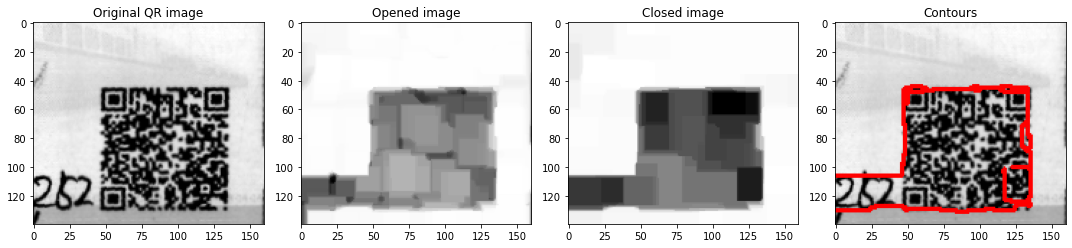

In [8]:
# 以2号图为例，当污染与二维码图产生粘连时，面积不能正确得到计算
ticket_img = "tickets/0002.bmp"
ticket_img = cv2.imread(ticket_img, cv2.IMREAD_GRAYSCALE)
r, c = ticket_img.shape
crop_img = ticket_img[int(r*0.5):r-30, int(c*0.7): c-5] 

plt.figure(figsize=(15, 15))
plt.subplot(141)
plt.imshow(crop_img, cmap='gray')
plt.title("Original QR image")

blurred_img = cv2.medianBlur(crop_img, 7)
blurred_img = 255 - blurred_img
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
morphed = cv2.morphologyEx(blurred_img, cv2.MORPH_OPEN, kernel)
top_hat = 255 - cv2.subtract(blurred_img, morphed)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
morphed_img = cv2.morphologyEx(top_hat, cv2.MORPH_OPEN, kernel)
plt.subplot(142)
plt.imshow(morphed_img, cmap='gray')
plt.title("Opened image")

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
morphed_img = cv2.morphologyEx(morphed_img, cv2.MORPH_CLOSE, kernel)
plt.subplot(143)
plt.imshow(morphed_img, cmap='gray')
plt.title("Closed image")

canny = cv2.Canny(morphed_img, 80, 150)
contours, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_img = cv2.cvtColor(crop_img, cv2.COLOR_GRAY2BGR)
contour_img = cv2.drawContours(contour_img, contours, -1, (255, 0, 0), 2)
plt.subplot(144)
plt.imshow(contour_img)
plt.title("Contours")
plt.tight_layout()

Text(0.5, 1.0, 'QR image')

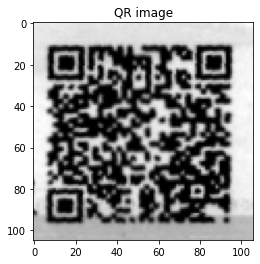

In [9]:
# 根据霍夫变换得到的直线，选择距离最接近标准二维码长度的两对边，认定为边界
def fetch_line(lines, shape):
    lines = abs(lines) 
    line_num = 4 # 横竖各考虑2条干扰线，太多会引入误差，太少容易漏掉真边
    standard_shape = 90 # 设定二维码标准长宽
    fetch_lines = np.zeros((2, line_num)) 
    cnt = [0, 0]
    for rho, theta in lines:
        mode = 0
        if theta < np.pi / 180 * 5 or np.pi - theta < np.pi / 180 * 5: # 竖线
            mode = 0
        elif abs(theta - np.pi / 2) < np.pi / 180 * 5: # 横线
            mode = 1
        else:
            continue
        if cnt[mode] >= line_num:
            continue

        for i in range(cnt[mode]):
            r = fetch_lines[mode][i]
            if abs(rho - r) <= 15: # 认为是同一条线，rho取更外围的值
                if rho > shape[0]/2 and rho > r:
                    fetch_lines[mode][i] = rho
                elif rho < shape[0]/2 and rho < r:
                    fetch_lines[mode][i] = rho
                break
        else:
            fetch_lines[mode][cnt[mode]] = rho
            cnt[mode] += 1
    # 取相邻两边距离最接近standard_shape的一对边
    fetch_lines = np.sort(fetch_lines, axis=1)
    result = np.zeros((2, 2))
    for mode in range(2):
        min = standard_shape
        for i in range(line_num):
            if fetch_lines[mode, i] == 0: continue
            for j in range(i+1, line_num):
                dis = fetch_lines[mode, j] - fetch_lines[mode, i] - standard_shape 
                if dis > 0 and dis < min:
                    min = dis
                    result[mode] = [fetch_lines[mode, i], fetch_lines[mode, j]]
    return np.uint8(result)

# 霍夫变换检测直线
lines = cv2.HoughLines(canny, 1, np.pi / 180, 10) # 参数
lines = lines.squeeze()

# 求解四条边界
fetch_lines = fetch_line(lines, canny.shape)
left, right, up, down = (*fetch_lines[0], *fetch_lines[1])
qr_img = crop_img[up-2:down+2, left-2:right+2]
plt.imshow(qr_img, cmap='gray')
plt.title("QR image")

## N 参考文献

[1]Huang Zhenghua, Wang Zhicheng, Zhang Jing, et al. Image enhancement with the preservation of brightness and structures by employing contrast limited dynamic quadri-histogram equalization. 2021, 226(P1)
https://schlr.cnki.net/Detail/index/SJESLAST/SJESC213D62F6C512BCE3E10F1C018DD6763

[2]张威.基于拉普拉斯变换的月球图像增强技术[J].中国新通信,2020,22(20):156-157.
https://kns.cnki.net/kcms/detail/detail.aspx?dbcode=CJFD&dbname=CJFDLAST2020&filename=TXWL202020079&v=0u459W2%25mmd2B0NIY3MDPVfK9xmqwpxUG9C3Idc6IyhyElwajcfrEEzISw3br2RwAH6BI
